In [30]:
import numpy as np
import os
import time
import corner
import astropy.io.fits as fits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import astropy.units as u
from astropy.wcs import WCS
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import matplotlib.pylab as pylab
import pandas as pd

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [31]:
import lenstronomy
assert lenstronomy.__version__ ==  "1.8.1"

In [32]:
SNR = 5.098 # known from original fits file
sky_zero_point = -21.1 # mag
photflam = 6.9548454E-20 # inverse sensitivity ergs/cm2/Ang/electron
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
psf2 = fits.open("../data/tiny_psf00_psf.fits")[0].data
im[im < 0] = 0
image_principales = np.loadtxt("../data/images_positions.txt")[:4] ## B, A, C, D, G, S
f_vega = 8.60e-10 
image_principales

array([[ 35.63010754, 101.14992219],
       [ 36.31652521,  71.48420784],
       [ 51.11519005,  43.54091825],
       [114.24860758,  93.42748217]])

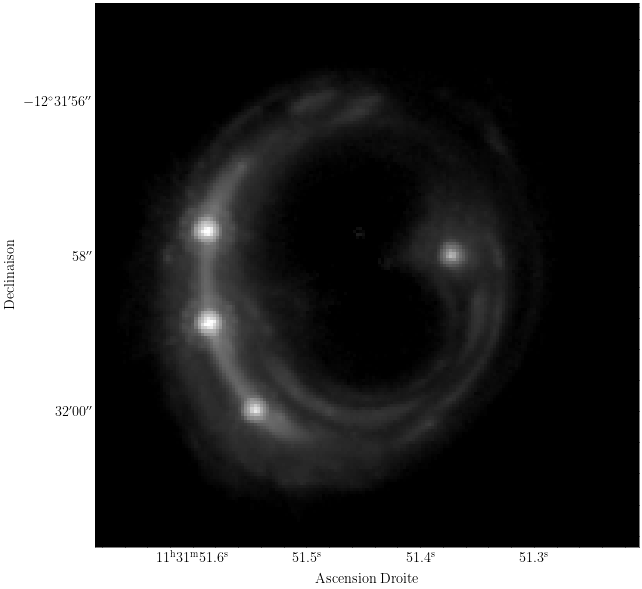

In [33]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

In [34]:
# coordinate system in arcseconds, centered
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
x_center = (lens_sky.ra[M//2]).to(u.arcsec)
y_center = (lens_sky.dec[M*N//2]).to(u.arcsec)

x_image = image_principales[:, 0][[1, 0, 2, 3]] # A, B, C, D
y_image = image_principales[:, 1][[1, 0, 2, 3]]
positions = wcs.pixel_to_world(x_image, y_image)
x_image = (positions.ra - lens_sky.ra.max()).to(u.arcsec).value
y_image = (positions.dec - lens_sky.dec.min()).to(u.arcsec).value
image_position = pd.DataFrame(np.column_stack([x_image, y_image]), columns=["theta_x", "theta_y"])
image_position

,theta_x,theta_y
0,-1.488295,2.859669
1,-1.460238,4.046300
2,-2.094626,1.741904
3,-4.681721,3.737226


In [35]:
x_center.to(u.hourangle)
# y_center.to(u.deg)

<Longitude 11.53095739 hourangle>

In [36]:
# time relative to first image (A) in order AB, Ac, and AD
delta_t = pd.DataFrame(np.array([[0.7, -0.4, 91.72], [1.4, 2, 1.5]]).T, columns=["delta_t", "sigma"])
delta_t.to_csv("../data/time_delays.csv")
delta_t

,delta_t,sigma
0,0.70,1.4
1,-0.40,2.0
2,91.72,1.5


In [37]:
# data specifics for the lens image
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 1.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
delta_pix_x = np.abs(lens_sky.ra[0] - lens_sky.ra[1]).to(u.arcsec).value
delta_pix_y = np.abs(lens_sky.dec[0] - lens_sky.dec[M]).to(u.arcsec).value
kwargs_data = {"image_data": im, "exposure_time": exp_time, 
               "background_rms": sigma_bkg, 
               "transform_pix2angle":np.array([[-delta_pix_x, 0], [0, delta_pix_y]]),
               "ra_at_xy_0": 0,
               "dec_at_xy_0": 0
               }
data_class = ImageData(**kwargs_data)

In [38]:
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.max()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value
grid = np.column_stack([x, y])
ee = 0.611 # encircled energy, source https://www.stsci.edu/hst/instrumentation/acs/data-analysis/aperture-corrections
# collect 4 pixels closest to the image position (correspond to 0.1 arcsec since pixelscale is 0.05 arcsec)
f = []
A = []
for i in range(4):
    pos = image_position.to_numpy()[i]
    diff = np.square(pos - grid.value)
    dist = np.einsum("ij -> i", diff)
    indexes = np.argpartition(dist, kth=4)[:4]
    A.append(np.sum(im.ravel()[indexes]))
    f.append(photflam * np.sum(im.ravel()[indexes])/ee) # see e.g. https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints
mag = np.array([-2.5 * np.log10(_f/f_vega) for _f in f])
mag

array([18.04465198, 18.08116562, 18.98110636, 20.35526269])

In [39]:
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image}]
#                            'point_amp': np.abs(mag)*1000}]  
point_source_list = ['LENSED_POSITION']
# point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

In [40]:
kwargs_psf = {'psf_type': "PIXEL", "kernel_point_source":psf, "pixel_size": delta_pix_x}

In [70]:
fixed_lens = [{}, {'ra_0': x_center, 'dec_0': y_center}]
fixed_source = [{"n_max": 7}]
fixed_ps = [{}]
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': x_center, 'center_y': y_center},
    {'gamma1': 0, 'gamma2': 0}]
# kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': x_center, 'center_y': y_center}]
kwargs_source_init = [{'amp': 1, 'beta': 0.2, 'center_x': x_center, 'center_y': y_center}]
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma1': 0.1, 'gamma2': 0.1}]
# kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_source_sigma = [{'amp': 0.1, 'beta': 0.05, 'center_x': 0.2, 'center_y': 0.2}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': x.min().value, 'center_y': y.min().value},
    {'gamma1': -0.5, 'gamma2': -0.5}]
# kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': x.min().value, 'center_y': y.min().value}]
kwargs_lower_source = [{'amp': 0, 'beta': 0.05, 'center_x': x.min().value, 'center_y': y.min().value}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': x.max().value, 'center_y': y.max().value},
    {'gamma1': 0.5, 'gamma2': 0.5}]
# kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': x.max().value, 'center_y': y.max().value}]
kwargs_upper_source = [{'amp': 10, 'beta': 5, 'center_x': x.max().value, 'center_y': y.max().value}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


In [71]:
fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

source_size_arcsec = 0.001
# If you want to keep the source size fixed during the fitting, outcomment the line below.
# fixed_special['source_size'] = source_size_arcsec
kwargs_special_init['source_size'] = source_size_arcsec
kwargs_special_sigma['source_size'] = source_size_arcsec
kwargs_lower_special['source_size'] = 0.0001
kwargs_upper_special['source_size'] = 1

kwargs_special_init['D_dt']= 5000
kwargs_special_sigma['D_dt'] = 10000
kwargs_lower_special['D_dt'] = 0
kwargs_upper_special['D_dt'] =  10000
special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]


# source_model_list = ['SERSIC_ELLIPSE']
source_model_list = ["SHAPELETS"]
lens_model_list = ['SPEP', 'SHEAR']

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
#                 'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': special_params}

kwargs_model = {'lens_model_list': lens_model_list, 
#                  'lens_light_model_list': lens_light_model_list,
                'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }



In [72]:
plate_scale = (delta_pix_x + delta_pix_y)/2
plate_scale

0.040488271391581065

In [73]:
# numerical options and fitting sequences


num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0, ["center_x", "center_y"]]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'check_matched_source_position': True,
                     'source_position_tolerance': plate_scale/10,
                     'time_delay_likelihood': True,
                     'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
                     'image_position_uncertainty': plate_scale,
                    }
kwargs_numerics = {'supersampling_factor': 1}
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'single-band',
                    'time_delays_measured': delta_t["delta_t"].to_numpy(),
                    'time_delays_uncertainties': delta_t["sigma"].to_numpy(),
                    'ra_image_list': [x_image], 'dec_image_list': [y_image]
                    }

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 20, 'n_iterations': 50}],
        ['MCMC', {'n_burn': 10, 'n_run': 50, 'walkerRatio': 10, 'sigma_scale': .2}]
]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

/home/alexandre/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/alexandre/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.04520606561458064 reduced X^2 of best position
-691.2685523453598 logL
30583.0 effective number of data points
[{'theta_E': 1.8183515046389847, 'gamma': 1.8551091699126652, 'e1': 0.05220076264098666, 'e2': -0.04332758107828333, 'center_x': -3.6613936468444086, 'center_y': 3.4439555928088623}, {'gamma1': -0.02488804847994809, 'gamma2': -0.00887709738970058, 'ra_0': -3.564959446899593, 'dec_0': 3.480186378576036}] lens result
[{'amp': 1, 'n_max': 7, 'beta': 0.20486800696821625, 'center_x': -3.16545409690673, 'center_y': 3.309641672471662}] source result
[] lens light result
[{'ra_image': array([-1.49084338, -1.48045418, -2.10602496, -4.67254239]), 'dec_image': array([2.85192147, 4.03713721, 1.74354668, 3.73706429]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{'D_dt': 1891.4488153699808} special param result
90.84857392311096 time used for  PSO


  0%|          | 0/60 [00:00<?, ?it/s]/home/alexandre/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 60/60 [11:09<00:00, 11.16s/it]

Computing the MCMC...
Number of walkers =  130
Burn-in iterations:  10
Sampling iterations (in current run): 60
680.2271349430084 time taken for MCMC sampling
771.189159154892 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


-0.05562491983717335 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.05562491983717336


/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/plot_util.py:199: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/plot_util.py:200: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')
/home/alexandre/Desktop/Projects/

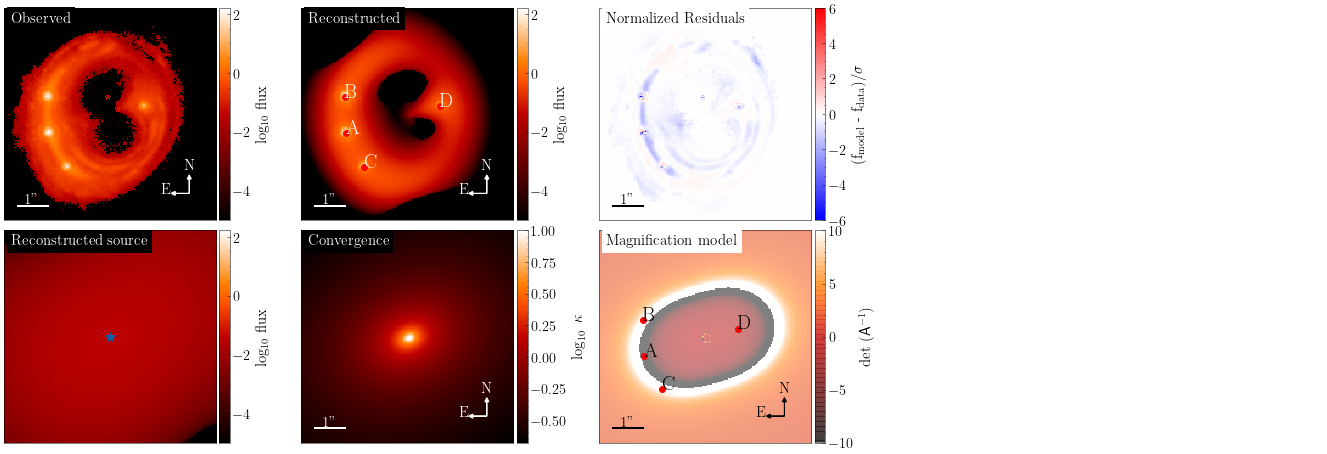

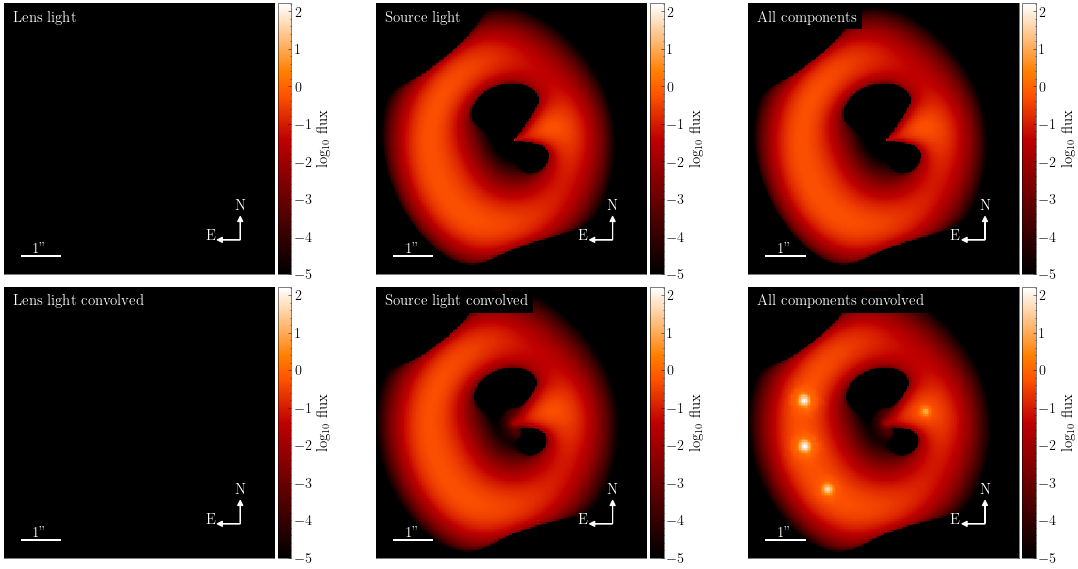

In [62]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = modelPlot.plot_main()
# f.show()
f, axes = modelPlot.plot_separate()
# f.show()
# f, axes = modelPlot.plot_subtract_from_data_all()
# f.show()


In [63]:
from lenstronomy.Analysis.td_cosmography import TDCosmography
from astropy.cosmology import Planck15 as cosmo
z_lens = 0.295
z_source = 0.658
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

In [66]:
# for i in range(len(chain_list)):
#     chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, None, fixed_source, fixed_ps, fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
lens_params_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
#     gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2 = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    gamma = kwargs_result["kwargs_lens"][0]["gamma"]
    theta_E = kwargs_result["kwargs_lens"][0]["theta_E"]
    e1, e2 = kwargs_result["kwargs_lens"][0]["e2"], kwargs_result["kwargs_lens"][0]["e1"]
    mcmc_new_list.append([delta_fermat_12, gamma1, gamma2, D_dt])
    lens_params_new_list.append([theta_E, gamma, e1, e2])




number of non-linear parameters in the MCMC process:  13
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  6500


IndexError: index 13 is out of bounds for axis 0 with size 13

In [67]:
mcmc_array = np.array(mcmc_new_list)
# remove negativ Ddt, I am not sure why this happens yet
mcmc_array_select = mcmc_array[mcmc_array[:, -1] > 1800]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

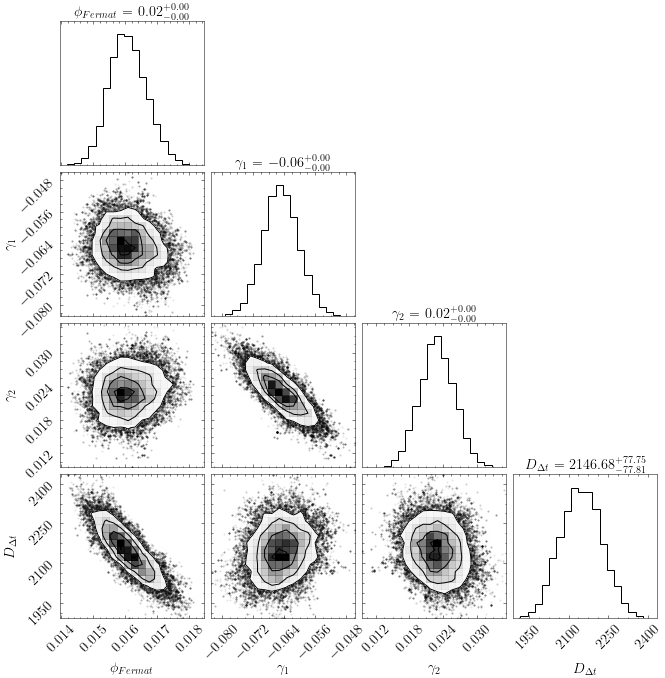

In [68]:
plot = corner.corner(mcmc_array_select, labels=labels_new, show_titles=True)

In [69]:
lens_label = [r"$\theta_E$", r"$\gamma$", r"$e_1$", r"$e_2$"]
plot = corner.corner(np.array(lens_params_new_list), labels=lens_label, show_titles=True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed